# 边缘检测

| 更新时间 | 负责人 | 内容 | 备注 |
| --- | --- | --- | --- |
| 2021年12月2日 | Rui | 初次编写文档 | ---- |
| 2022年12月15日 | Rui | 修改文档的编写方式 | 使用 Jupyter notebook 进行编写文档 |
| 2022年1月18日 | Rui | 修改文档，增加效果图 | 通过测试的平台有 MaixII-Dock，使用的是 MaixPy3 0.4.0 |
|2022年2月2日 | DLS | 修改部分代码 | MaixPy3 更新到0.4.6 支持 R329.  |




通过(卷积/conv)实现 sobel(索贝尔) 边缘检测

## 运行效果

![](./../asserts/sobel_v831.jpg)

<p align="center">
  <iframe src="//player.bilibili.com/player.html?aid=808373936&bvid=BV1F34y1q7TB&cid=487496493&page=1" scrolling="no" border="0" frameborder="no" framespacing="0" allowfullscreen="true" style="max-width:640px; max-height:480px;"> </iframe>
</p>

## 准备

- 确认 MaixPy3 版本为 0.4.3 以上
- 使用的硬件为 MaixII-Dock
- 内存卡内是最新版本的镜像系统
- 插卡启动硬件

## 边缘检测

### 部署到 MaixII-Dock 上

- 在 [MaixHub](https://www.maixhub.com/modelInfo?modelId=24) 上获取模型文件和运行源码（最新 0.4.7 版本的系统内置了模型文件 `/home/model/sobel_int8.*`）

In [1]:
global Edge
class Edge:
    model = {
        "param": "/home/model/sobel_int8.param",
        "bin": "/home/model/sobel_int8.bin"
    }
    input_size = (224, 224, 3)
    output_size = (222, 222, 3)
    options = {
        "model_type":  "awnn",
        "inputs": {
            "input0": input_size
        },
        "outputs": {
            "output0": output_size
        },
        "mean": [127.5, 127.5, 127.5],
        "norm": [0.0078125, 0.0078125, 0.0078125],
    }
    def __init__(self):
        from maix import nn
        print("-- load model:", self.model)
        self.model = nn.load(self.model, opt=self.options)
        print("-- load ok")
    def __del__(self):
        del self.model
print(Edge)


[ rpyc-kernel ]( running at Fri Mar 11 14:07:06 2022 )
-- load model: {'param': '/home/model/sobel_int8.param', 'bin': '/home/model/sobel_int8.bin'}
-- load ok


### 部署到 MaixSense 上

0.4.8 后系统镜像已经内置了模型文件（`/home/model/aipu_sobel.bin`）

In [ ]:
global Edge
class Edge:
    path = {
        "bin": "/home/model/aipu_sobel.bin"
    }
    input_size = (224,224,3)
    output_size = (224,224,3)
    options = {
        "model_type":  "aipu",
        "inputs": {
            "input0": input_size
        },
        "outputs": {
            "output0": output_size
        },
        "mean": [127.5, 127.5, 127.5],
        "norm": [0.0078125, 0.0078125, 0.0078125],
        "scale":[0.15196067], # R329 有此选项，V831没有这个选项
    }
    def __init__(self) -> None:
        from maix import nn
        print(" - - load model :",self.path)
        self.model = nn.load(self.path , opt = self.options)
        print("- -load ok")
    def __del__(self):
        del self.model
print(Edge)


### 开始进行边缘检测

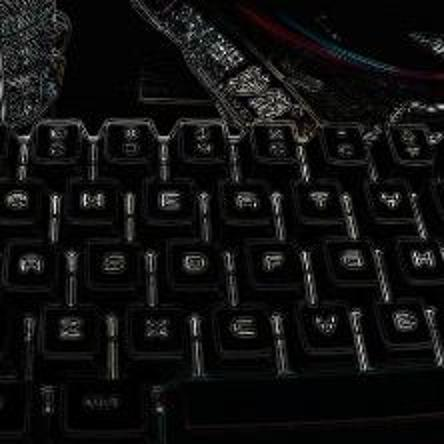


Traceback (most recent call last):
  File "<string>", line unknown, in <module>
Remote.KeyboardInterrupt


In [1]:
from maix import camera, display
import numpy as np
m = Edge()
while True:
    img = camera.capture().resize(224,224)
    out = m.model.forward(img, quantize=True, layout="hwc")
    out = out.astype(np.float32).reshape(m.output_size)
    out = (np.ndarray.__abs__(out) * 255 / out.max()).astype(np.uint8)
    data = out.tobytes()
    img2 = img.load(data,(222, 222), mode="RGB")
    display.show(img2)

## 了解更多

可以查看 Neutree 的[博客](https://neucrack.com/p/377)，了解边缘检测开发过程